In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [2]:
CD20=fdata.loc[:,['Current at 2.0 V']]

In [3]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [4]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,8,0.1)
    x_y_y=np.arange(0,8,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@2.0V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@2.0V (vs. RHE)")
    plt.savefig('CD20 SEL %s.png' %algorithm_name)
    print('finished')

In [5]:
seed=97
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD20, test_size=.15,random_state=seed)

In [6]:
train=pd.concat([X_train,y_train],axis=1)
train.to_csv('REG20_train.csv')
test=pd.concat([X_test,y_test],axis=1)
test.to_csv('REG20_test.csv')

In [6]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD20
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LightGBM
[ 856 1049]
Best Regressor: {} Best Score: 0.2905597939274096
(0.09820203027803558, 0.02073922212936497, 0.14401118751459893, -0.38877948242557414) TEST R2 -0.38877948242557414 TEST CORR 0.53542
(0.077926144707132, 0.012213193096400309, 0.11051331637590245, 0.04127154029732183) TRAIN R2 0.04127154029732183 TRAIN CORR 0.7831
finished
XGBoost
[0.50497097 0.495029  ]
Best Regressor: {} Best Score: 0.3161391066118678
(0.08292883107695086, 0.015649442443689893, 0.12509773156892132, 0.16683464638905532) TEST R2 0.16683464638905532 TEST CORR 0.67762
(0.01743587616283667, 0.0013023521861982032, 0.036088116966644344, 0.9499087506042655) TRAIN R2 0.9499087506042655 TRAIN CORR 0.97955
finished


KeyboardInterrupt: 

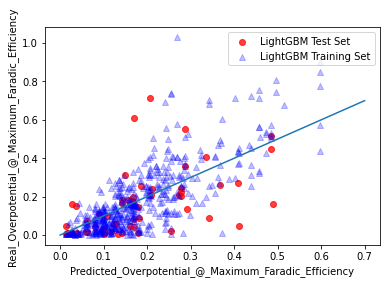

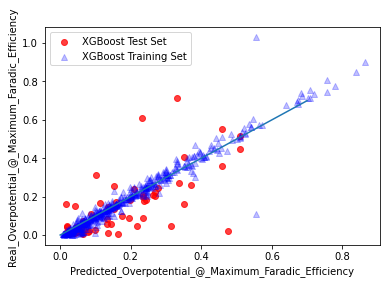

In [8]:
# ##########LGBM gridsearch CV for best hyperparameter##########
# model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
# param_light = {
# 'boosting_type':['gbdt','rf'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[5,7,9,11,13,-1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

# ##########XGBoost gridsearch CV for best hyperparameter##########
# model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
# param_xg = {
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[5,7,9,11,13],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_XGBRegressor,param_xg,'XGBoost')

# ##########CatBoost gridsearch CV for best hyperparameter##########
# model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
# param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5],
# 'n_estimators':[50,100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_CatRegressor,param_cat,'CatBoost')


# ###########GradientBoost gridsearch CV for best hyperparameter##########
# model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_GB = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[3,5,7,9,11,13,16],
# 'criterion':['friedman_mse','mae','mse'],
# 'max_features':['auto','sqrt','log2'],
# 'loss':['ls', 'lad', 'huber', 'quantile']
# }
# gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

# ###########RandomForest gridsearch CV for best hyperparameter##########
# model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
# }
# gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


# ###########Extra Tree gridsearch CV for best hyperparameter##########
# model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
# param_ET = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')


# ###########Decision Tree gridsearch CV for best hyperparameter##########
# model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
# param_DT = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')


# ###########AdaBoost gridsearch CV for best hyperparameter##########
# model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
# param_Ada = {
# 'n_estimators':[50,100,200,400,800],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'loss':['linear', 'square', 'exponential']
# }
# gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

Converting column-vector to 1d array


LightGBM
[152 106  74  53  14  54 275 118 153 212 137  88  53]
Best Regressor: {'boosting_type': 'gbdt', 'learning_rate': 0.15, 'max_depth': 9, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.4} Best Score: 0.6983925843968212
(0.41622315733051485, 0.3099676379760611, 0.5567473735690731, 0.874922835532186) TEST R2 0.874922835532186 TEST CORR 0.94671
(0.30209810877853766, 0.3518508029587282, 0.5931701298605049, 0.8756359166802035) TRAIN R2 0.8756359166802035 TRAIN CORR 0.94697
finished


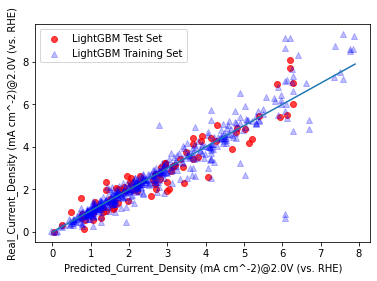

In [7]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt'],
'learning_rate':[0.15],
'subsample':[0.4],
'n_estimators':[100],
'max_depth':[9],
'reg_alpha':[0],
'reg_lambda':[0]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

In [9]:
%matplotlib
shap_plot(model_LightGBMRegressor,param_light,'LightGBM')

Using matplotlib backend: Qt5Agg
LightGBM


Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array


[0.45566946 0.06145588 0.10386322 0.05573958 0.03653459 0.06692696
 0.25103052 0.15505378 0.26683947 0.16575417 0.13939878 0.65266557
 0.13979721]


In [10]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.12],
'n_estimators':[100],
'max_depth':[13],
'subsample':[0.4],
'reg_alpha':[0.0001],
'reg_lambda':[1e-05]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.03011198 0.01538848 0.02458633 0.02970685 0.08137644 0.05662167
 0.02987841 0.03541461 0.0745623  0.0761949  0.0398111  0.32433584
 0.18201108]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.12, 'max_depth': 13, 'n_estimators': 100, 'reg_alpha': 0.0001, 'reg_lambda': 1e-05, 'subsample': 0.4} Best Score: 0.7019271642644276
(0.3720800788784447, 0.2968202667277683, 0.5448121389320986, 0.8985103291310537) TEST R2 0.8985103291310537 TEST CORR 0.95087
(0.12705529361458137, 0.197713104267459, 0.4446494172575277, 0.9377563160947198) TRAIN R2 0.9377563160947198 TRAIN CORR 0.97027
finished


In [11]:
shap_plot(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.45004685 0.10382095 0.07597265 0.07611024 0.06005673 0.10942342
 0.19374423 0.09973394 0.17743104 0.19745806 0.09763199 0.71645786
 0.26074441]


In [12]:
##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {

'max_depth':[11],
'boosting_type':['Plain'],
'subsample':[0.4],
'reg_lambda':[0.001]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[17.78918567  4.7271602   5.04348719  2.97791228  2.75499439  6.67281506
  9.78078658  5.27000936 11.77583363  8.10344815  6.55991688 14.63507049
  3.90938014]
Best Regressor: {'boosting_type': 'Plain', 'max_depth': 11, 'reg_lambda': 0.001, 'subsample': 0.4} Best Score: nan
(0.38196514705286666, 0.3251494094788089, 0.5702187382740144, 0.8851539689072695) TEST R2 0.8851539689072695 TEST CORR 0.94602
(0.11407125844449166, 0.19495822173232288, 0.4415407362093818, 0.9383291336315269) TRAIN R2 0.9383291336315269 TRAIN CORR 0.9707
finished


In [13]:
shap_plot(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[0.37115737 0.12004344 0.09261386 0.05639347 0.06006778 0.07071965
 0.20040878 0.09795794 0.18819723 0.11582706 0.15835618 0.47168774
 0.1480512 ]


In [14]:
###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.08],
'n_estimators':[400],
'max_depth':[3],
'criterion':['friedman_mse'],
'max_features':['sqrt'],
'loss':['huber']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoost
[0.1642209  0.06047674 0.03135807 0.04253527 0.00884821 0.04422085
 0.12233867 0.03531157 0.06313913 0.06411075 0.10800219 0.19956867
 0.05586897]
Best Regressor: {'criterion': 'friedman_mse', 'learning_rate': 0.08, 'loss': 'huber', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 400} Best Score: 0.7034049537899468
(0.3539135182119557, 0.21657736126454477, 0.4653787288483916, 0.9200777083550287) TEST R2 0.9200777083550287 TEST CORR 0.96346
(0.2777882312600266, 0.40580004859621077, 0.6370243704884537, 0.8683513059093491) TRAIN R2 0.8683513059093491 TRAIN CORR 0.93818
finished


In [15]:
shap_plot(model_GradientBoostingRegressor,param_GB,'GradientBoost')

GradientBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.47641352 0.10999583 0.11246597 0.06315574 0.02433156 0.09118867
 0.21211132 0.22058367 0.17827265 0.17323327 0.1563778  0.5656957
 0.22959505]


In [16]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[400],
'max_depth':[None],
'criterion':['mae'],
'max_features':['auto']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
[0.17054631 0.05049345 0.04066421 0.02999867 0.01278337 0.07024831
 0.11580531 0.05070325 0.11347591 0.07292344 0.04122287 0.19268989
 0.03844501]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 400} Best Score: 0.6768418021215817
(0.3541782587152164, 0.24292715431643705, 0.49287640876434435, 0.9055648498444674) TEST R2 0.9055648498444674 TEST CORR 0.9599
(0.2536089751113465, 0.2746797769966512, 0.5240990144969281, 0.9002218576568921) TRAIN R2 0.9002218576568921 TRAIN CORR 0.96015
finished


In [17]:
shap_plot(model_RandomForestRegressor,param_RF,'Random Forest')

Random Forest


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 99%|===================| 570/578 [00:31<00:00]        

[0.39995338 0.06339264 0.05975131 0.0316208  0.02616759 0.10656263
 0.19083827 0.1048096  0.23781214 0.08229964 0.05416119 0.79379861
 0.09719151]


In [18]:
###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[11],
'max_features':['auto'],
'criterion' : ["friedman_mse"],
'splitter' : [ 'random']
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.1297563  0.01365594 0.03725786 0.01036361 0.05882459 0.08767227
 0.06081862 0.01155348 0.09863213 0.02168268 0.08926356 0.29444173
 0.08607722]
Best Regressor: {'criterion': 'friedman_mse', 'max_depth': 11, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.5998813985180744
(0.4748640604033272, 0.36299460959112667, 0.6024903398322057, 0.8928034809440879) TEST R2 0.8928034809440879 TEST CORR 0.94734
(0.28511975590689254, 0.32901156272010806, 0.5735952952388191, 0.8919981085503899) TRAIN R2 0.8919981085503899 TRAIN CORR 0.95001
finished


In [19]:
shap_plot(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.46541658 0.06590257 0.08750449 0.07706531 0.19930261 0.19682856
 0.14161725 0.05431715 0.18973057 0.04845822 0.14296898 0.59620697
 0.35137568]


In [20]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[11],
'max_features':['auto'],
'criterion' : ["friedman_mse"],
'splitter' : [ 'random']
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.1297563  0.01365594 0.03725786 0.01036361 0.05882459 0.08767227
 0.06081862 0.01155348 0.09863213 0.02168268 0.08926356 0.29444173
 0.08607722]
Best Regressor: {'criterion': 'friedman_mse', 'max_depth': 11, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.5998813985180744
(0.4748640604033272, 0.36299460959112667, 0.6024903398322057, 0.8928034809440879) TEST R2 0.8928034809440879 TEST CORR 0.94734
(0.28511975590689254, 0.32901156272010806, 0.5735952952388191, 0.8919981085503899) TRAIN R2 0.8919981085503899 TRAIN CORR 0.95001
finished


In [21]:
shap_plot(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.46541658 0.06590257 0.08750449 0.07706531 0.19930261 0.19682856
 0.14161725 0.05431715 0.18973057 0.04845822 0.14296898 0.59620697
 0.35137568]


In [22]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[100],
'learning_rate':[0.12],
'loss':['exponential']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoost
[0.09097825 0.0060682  0.00490634 0.02861582 0.00982635 0.04274652
 0.1283672  0.01368576 0.14116663 0.0395481  0.04119943 0.40945868
 0.04343272]
Best Regressor: {'learning_rate': 0.12, 'loss': 'exponential', 'n_estimators': 100} Best Score: 0.5373543068200587
(0.7026113357593066, 0.8389812169090279, 0.915959178625897, 0.48548986363422164) TEST R2 0.48548986363422164 TEST CORR 0.85365
(0.8350909817229384, 1.1516835356216515, 1.073165194935827, 0.2581928988289425) TRAIN R2 0.2581928988289425 TRAIN CORR 0.82531
finished


In [23]:
shap_plot(model_AdaBoostRegressor,param_Ada,'AdaBoost')

AdaBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.23563073 0.02348132 0.00908673 0.03134429 0.03484229 0.04322239
 0.2141849  0.02517583 0.20328161 0.0417446  0.06147016 0.58143913
 0.12652658]
